### Replicating the LSTM demo from "How to apply LSTM using PyTorch" (AHMAD ANIS) on one flight path:
https://cnvrg.io/pytorch-lstm/

**Note to self: i can/should condense the code if i make more def (functions) for repeatable code.**
* def for preprosessing data
* def for comparing trained model to all data
* def for reformating output
* def for plotting visuals
* def for rmse

Overall, it looks like my lstm isn't performing as well as i would have hope...especialy for the lon values. Might try other flight paths, or linear regression. ¯\_(ツ)_/¯

In [1]:
#importing necessary packages
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#import contextily-->trying to use to add basemaps
import sklearn.metrics
import math

### Flight a198e5 
This flight is an arrival to Chicago's airport. There are many recorded points near the end of its flight that are from the same location (becasue it has docked for deboarding). It does represent altitude change, and likely would be affected by airspace B classification. 

In [2]:
#reading and inspecting the data for one flight called 'a198e5'
df = pd.read_csv('a198e5.csv', index_col = 'time', parse_dates = True)
print(len(df))
df.head(3)


228


,OBJECTID,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,spi,squawk,baroaltitu,geoaltitud,lastposupd,lastcontac
time,,,,,,,,,,,,,,,,
1590364810,1,a198e5,39.353851,-85.572987,245.514862,342.438279,-0.32512,EJM16,False,False,False,2212,9144.0,9532.62,1.590365e+09,1.590365e+09
1590364820,2,a198e5,39.375698,-85.581909,249.258603,342.462562,0.00000,EJM16,False,False,False,2212,9144.0,9532.62,1.590365e+09,1.590365e+09
1590364830,3,a198e5,39.395966,-85.590124,252.511839,342.450998,0.32512,EJM16,False,False,False,2212,9144.0,9532.62,1.590365e+09,1.590365e+09


In [3]:
# REPLACING ALL NAN values in my altitude column for 0 (becasue it is on the ground they no longer report the alt)
#a nessacery step if i hope to predict altiude (LSTM doesn't work with nan)
df['geoaltitud'] = df['geoaltitud'].fillna(0)

#inspect data to make sure it worked
#df.tail(5)

### Choosing which variables I will predict and which variables will help predict the dependant variables. 

predictors (independent variables):
`velocity`
`heading`
`vertrate`
`lastposupd`
`lastcontac`

predicted (dependant variables):
`lat`
`lon`

In [4]:
# Looks like x retains all the data used to prdict y... (velocity, heading, vertrate, latposupd, and lastcontact)
x = df.iloc[:,4:16]
x = df.drop("callsign", axis=1)
x = x.drop("onground", axis=1)
x = x.drop("alert", axis=1)
x = x.drop("spi", axis=1)
x = x.drop("squawk", axis=1)
x = x.drop("baroaltitu", axis=1)
x = x.drop("geoaltitud", axis=1)
x = x.iloc[:, 4:9]
# y are both the lat and lon columns (later try and predict alt as well...)
y =df.iloc[:, 2:4]

x

,velocity,heading,vertrate,lastposupd,lastcontac
time,,,,,
1590364810,245.514862,342.438279,-0.32512,1.590365e+09,1.590365e+09
1590364820,249.258603,342.462562,0.00000,1.590365e+09,1.590365e+09
1590364830,252.511839,342.450998,0.32512,1.590365e+09,1.590365e+09
1590364840,254.628994,342.480241,0.00000,1.590365e+09,1.590365e+09
1590364850,257.236918,342.543442,0.00000,1.590365e+09,1.590365e+09
...,...,...,...,...,...
1590367040,57.867519,43.198839,-2.27584,1.590367e+09,1.590367e+09
1590367050,57.867519,43.198839,-2.27584,1.590367e+09,1.590367e+09
1590367060,57.867519,43.198839,-2.27584,1.590367e+09,1.590367e+09


In [5]:
# rescaling all of my data....(based on the tutorial) y-> MinMax and x -> standard
#mm used to scale values between 0-1
mm = MinMaxScaler()
ss = StandardScaler()

x_ss = ss.fit_transform(x)
y_mm = mm.fit_transform(y)

#now an array, with values varying between 0.46 and 2.59? Has a len of 253, the number row in the Starbuck_data
#len(x_ss)

#values between 0 and 1
#y_mm

## spliting the data into 2 parts (train and test)

In [6]:
# may need to chhoose other arbitary threshold...this leaves 28 point for testing
#the first 200 for training,

x_train = x_ss[:200,:] #first 200 rows
x_test = x_ss[200:,:] #whatever remains after 200


y_train = y_mm[:200, :]
y_test = y_mm[200:,:]

print("Training Shape", x_train.shape, y_train.shape)
print("Testing Shape", x_test.shape, y_test.shape) 

Training Shape (200, 5) (200, 2)
Testing Shape (28, 5) (28, 2)


### convert our numpy to tensors

In [7]:
x_train_tensors = Variable(torch.Tensor(x_train))
x_test_tensors = Variable(torch.Tensor(x_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

#x_train_tensors

## adding another dimension to tensors, for time

In [8]:
#import format for lSTMs needs to have each TIMESTAMP
#reshaping to rows, timestamps, features

x_train_tensors_final = torch.reshape(x_train_tensors,   (x_train_tensors.shape[0], 1, x_train_tensors.shape[1]))
x_test_tensors_final = torch.reshape(x_test_tensors,  (x_test_tensors.shape[0], 1, x_test_tensors.shape[1])) 

#comparing the tensor_final with the previous there is another dimension... why? for the timestamp?
print("Training Shape", x_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", x_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 2])
Testing Shape torch.Size([28, 1, 5]) torch.Size([28, 2])


### Building the LSTM

based entirely on the demo

In [9]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes (number of output variables)
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size  (number of input variables)
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    #pass in input a t time t
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out
    
    

In [10]:
# defining some input variables

#frist 2 variables aren't part of the defined input parameter?? when are they used?- Later when we train the lstm
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 2 #number of output classes

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, x_train_tensors_final.shape[1])
lstm1

LSTM1(
  (lstm): LSTM(5, 2, batch_first=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
)

In [11]:
#defining our loss funstion and optimizer...
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

# now we will loop pver each epoch, calculate a loss, and imporve weights via the optimizer
for epoch in range(num_epochs):
    outputs = lstm1.forward(x_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
 
    loss.backward() #calculates the loss of the loss function
 
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.56683
Epoch: 100, loss: 0.08804
Epoch: 200, loss: 0.02262
Epoch: 300, loss: 0.01225
Epoch: 400, loss: 0.00679
Epoch: 500, loss: 0.00577
Epoch: 600, loss: 0.00545
Epoch: 700, loss: 0.00530
Epoch: 800, loss: 0.00519
Epoch: 900, loss: 0.00511


### Comparing with test data (?)

In [12]:
# don't actually know what's happening here...
df_X_ss = ss.transform(x) #old transformers
df_y_mm = mm.transform(y) #old transformers

#print(df_X_ss, len(df_X_ss)) #looks the same when we previously used .fit_transform

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 



In [13]:
# looking at our LSTM performance
train_predict = lstm1(df_X_ss)#forward pass for all data rows
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)


In [14]:
# must reshape the data so i can plot it...
dataY_plot_f = dataY_plot.flatten()
p_lat = []
p_lon = []
a_lat = []
a_lon = []
for index, element in enumerate(dataY_plot_f):
    if index % 2 == 0:
        a_lat.append(element)
    else:
        a_lon.append (element)
        
data_predict_f = data_predict.flatten()
for index, element in enumerate(data_predict_f):
    if index % 2 == 0:
        p_lat.append(element)
    else:
        p_lon.append (element)

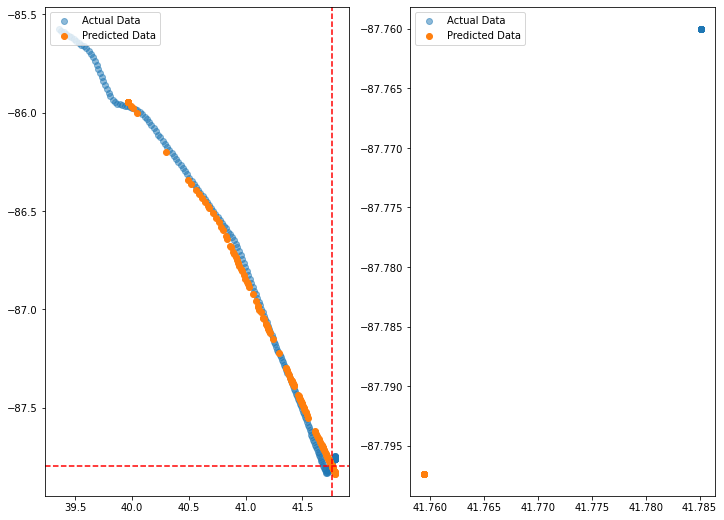

In [15]:
# the data is too spread out for me to see actual comparisons at the decimal level.... 
# either (1)  plot just the results for the lat (linerally) then the long (linerally)
#        (2)  or plot lat/long as a scatterplot 

f, ax = plt.subplots(1,2, figsize=(12, 9))
ax[0].scatter(a_lat,a_lon, label='Actual Data', alpha= .5)#actual data
ax[0].legend(loc='upper left')
ax[0].scatter(p_lat,p_lon, label='Predicted Data')
ax[0].legend(loc='upper left')
ax[0].axvline(x=p_lat[199], c='r', linestyle='--')
ax[0].axhline(y=p_lon[199], c='r', linestyle='--')
ax[0].set_title('Flight a198e5')

ax[1].scatter(a_lat[200:],a_lon[200:], label='Actual Data', alpha= .5)#actual data
ax[1].legend(loc='upper left')
ax[1].scatter(p_lat[200:],p_lon[200:], label='Predicted Data')
ax[1].legend(loc='upper left')
ax[1].set_title('Predictions for Flight a198e5')
#data_predict


In [16]:
mse_lat = sklearn.metrics.mean_squared_error(a_lat, p_lat)
rmse_lat = math.sqrt(mse_lat)
mse_lon = sklearn.metrics.mean_squared_error(a_lon, p_lon)
rmse_lon = math.sqrt(mse_lon)

#error based on all of the data (training and test)
print("lat error:", rmse_lat, "lon error:", rmse_lon)

mse_lat_test = sklearn.metrics.mean_squared_error(a_lat[200:], p_lat[200:])
rmse_lat_test = math.sqrt(mse_lat_test)
mse_lon_test = sklearn.metrics.mean_squared_error(a_lon[200:], p_lon[200:])
rmse_lon_test = math.sqrt(mse_lon_test)

#Notices the error is larger when looking at only the test data. RMSE is measured in degrees 
print("lat error:", rmse_lat_test, "lon error:", rmse_lon_test)

#what does this mean in terms of meters or another unit of measure? 
    #converting degrees to meters is a problem, and depends on where in the globe the degree is... 

lat error: 0.18310829669040177 lon error: 0.12896144292247885
lat error: 0.02564239501953125 lon error: 0.0373382568359375


# Results and possible conclusions
Based on this graph, I can surmise that the LSTM predicted the aircraft wouldn't move near the end of the data (after 200th observation or so). I believe it reached these conculsions since the x data (the variables velocity, heading, vertrate, etc.) didn't show much changes since this specific flight is one that has arrived at O'Hare Internation Airport and thus has little movement in near the end of its timed oberservation. 

Looking at the RMSE for the entire flight path (which would include accruarcy measre for training and testing data) and the RMSE only for the test data, you can see our test data has less error. This may be due to the fact that the last 20 pts for this flight are the same, and thus have the same error (consistency). 

**Need To Do**
* I want to try and use this flight path but only look at predicting up to where it stops moving (need to subset the data again by concatinating it on the end). 
* I have yet to incorporate weather data or airspace classifcation into the model. Nor do i understand or know how to twick the currrent LSTM for a better performance (change the optimizers, more epochs, nore hidden layers, ????)

**Look further at the flight 89902f** 
* I would still like to explore how this would work for a non-arrival flight (or a non-linear/predictable flight path). 


## flight 89902f (neither arrival nor departure)
This flight maitains a crusing altitude that passes chicago's airport moving in an NW direction.  

In [17]:
#reading and inspecting the data
df1 = pd.read_csv('flight_89902f.csv', index_col = 'time', parse_dates = True)
print(len(df1))
df1.head(3)

342


,OBJECTID,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,spi,squawk,baroaltitude,geoaltitude,lastposupdate,lastcontact
time,,,,,,,,,,,,,,,,
1590364980,1,89902f,46.315008,-95.859421,238.720863,123.039396,0.0,EVA056,False,False,False,NaN,11277.6,11574.78,1.590365e+09,1.590365e+09
1590364990,2,89902f,46.306814,-95.841225,239.152284,122.972199,0.0,EVA056,False,False,False,NaN,11277.6,11567.16,1.590365e+09,1.590365e+09
1590365000,3,89902f,46.291489,-95.807145,239.152284,122.972199,0.0,EVA056,False,False,False,NaN,11277.6,11574.78,1.590365e+09,1.590365e+09


## data Preprocessing

In [18]:
# Looks like x retains all the data used to predict y... (velocity, heading, vertrate, latposupd, and lastcontact)
x = df1.iloc[:,4:16]
x = df1.drop("callsign", axis=1)
x = x.drop("onground", axis=1)
x = x.drop("alert", axis=1)
x = x.drop("spi", axis=1)
x = x.drop("squawk", axis=1)
x = x.drop("baroaltitude", axis=1)
x = x.drop("geoaltitude", axis=1)
x = x.iloc[:, 4:9]
# y are both the lat and lon columns (later try and predict alt as well...)
y =df1.iloc[:, 2:4]

#print(x, y)
# rescaling Data
#mm used to scale values between 0-1
mm = MinMaxScaler()
ss = StandardScaler()

x_ss = ss.fit_transform(x)
y_mm = mm.fit_transform(y)

#print(x_ss, y_mm)
#Splitting Data (test and train)
#the first 275 for training,

x_train = x_ss[:315,:] #first 275 rows
x_test = x_ss[315:,:] #whatever remains after 275


y_train = y_mm[:315, :]
y_test = y_mm[315:,:]

print("Training Shape", x_train.shape, y_train.shape)
print("Testing Shape", x_test.shape, y_test.shape) 

#convert to tensors
x_train_tensors = Variable(torch.Tensor(x_train))
x_test_tensors = Variable(torch.Tensor(x_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

# adding another dimension for time
x_train_tensors_final = torch.reshape(x_train_tensors,   (x_train_tensors.shape[0], 1, x_train_tensors.shape[1]))
x_test_tensors_final = torch.reshape(x_test_tensors,  (x_test_tensors.shape[0], 1, x_test_tensors.shape[1])) 

#comparing the tensor_final with the previous there is another dimension... why? for the timestamp?
print("Training Shape", x_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", x_test_tensors_final.shape, y_test_tensors.shape)

Training Shape (315, 5) (315, 2)
Testing Shape (27, 5) (27, 2)
Training Shape torch.Size([315, 1, 5]) torch.Size([315, 2])
Testing Shape torch.Size([27, 1, 5]) torch.Size([27, 2])


## LSTM params

In [19]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 2 #number of output classes

lstm2 = LSTM1(num_classes, input_size, hidden_size, num_layers, x_train_tensors_final.shape[1])
lstm2

#defining our loss funstion and optimizer...
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm2.parameters(), lr=learning_rate) 

# now we will loop over each epoch, calculate a loss, and imporve weights via the optimizer
for epoch in range(num_epochs):
    outputs = lstm2.forward(x_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
 
    loss.backward() #calculates the loss of the loss function
 
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        
#why is my LSTM not improving????? ---BECAUSE of a TYPO!!

Epoch: 0, loss: 0.23411
Epoch: 100, loss: 0.00409
Epoch: 200, loss: 0.00160
Epoch: 300, loss: 0.00073
Epoch: 400, loss: 0.00037
Epoch: 500, loss: 0.00022
Epoch: 600, loss: 0.00015
Epoch: 700, loss: 0.00011
Epoch: 800, loss: 0.00009
Epoch: 900, loss: 0.00007


## Results and Visuals

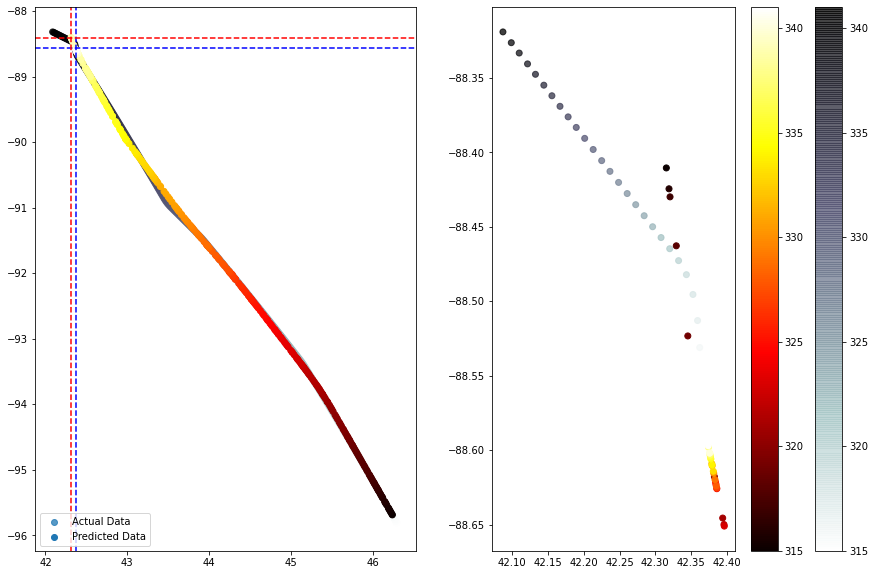

In [20]:
# don't actually know what's happening here...
df_X_ss = ss.transform(x) #old transformers
df_y_mm = mm.transform(y) #old transformers

#print(df_X_ss, len(df_X_ss)) #looks the same when we previously used .fit_transform

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

# looking at our LSTM performance
train_predict = lstm2(df_X_ss)#forward pass for all data rows
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

# must reshape the data so i can plot it...
dataY_plot_f = dataY_plot.flatten()
p_lat = []
p_lon = []
a_lat = []
a_lon = []
for index, element in enumerate(dataY_plot_f):
    if index % 2 == 0:
        a_lat.append(element)
    else:
        a_lon.append (element)
        
data_predict_f = data_predict.flatten()
for index, element in enumerate(data_predict_f):
    if index % 2 == 0:
        p_lat.append(element)
    else:
        p_lon.append (element)

#added this code in hopes of coloring direction/time of my test data.
indexlist=[]
for i, value in enumerate(a_lat):
    indexlist.append(i)
#print(len(indexlist))

#plot of newest lstm        
f, ax = plt.subplots(1,2, figsize=(15, 10))
ax[0].scatter(a_lat,a_lon, label='Actual Data', alpha= .75, c=indexlist, cmap = 'bone_r')#)#actual data
ax[0].legend(loc='lower left')
ax[0].scatter(p_lat,p_lon, label='Predicted Data', c=indexlist, cmap = 'hot')
ax[0].legend(loc='lower left')
ax[0].axvline(x=a_lat[314], c='b', linestyle='--')
ax[0].axhline(y=a_lon[314], c='b', linestyle='--')
ax[0].axvline(x=p_lat[314], c='r', linestyle='--')
ax[0].axhline(y=p_lon[314], c='r', linestyle='--')
ax[0].set_title('Flight 89902f')

pl1 = ax[1].scatter(a_lat[315:],a_lon[315:], label='Actual Data', alpha= .75, c=indexlist[315:], cmap = 'bone_r')#actual data
plt.colorbar(pl1)
pl2 = ax[1].scatter(p_lat[315:],p_lon[315:], label='Predicted Data', c=indexlist[315:], cmap = 'hot')
plt.colorbar(pl2)
ax[1].set_title('Prediction for Flight 89902f')
#data_predict

In [21]:
mse_lat = sklearn.metrics.mean_squared_error(a_lat, p_lat)
rmse_lat = math.sqrt(mse_lat)
mse_lon = sklearn.metrics.mean_squared_error(a_lon, p_lon)
rmse_lon = math.sqrt(mse_lon)

#error based on all of the data (training and test)
print("lat error:", rmse_lat, "lon error:", rmse_lon)

mse_lat_test = sklearn.metrics.mean_squared_error(a_lat[299:], p_lat[299:])
rmse_lat_test = math.sqrt(mse_lat_test)
mse_lon_test = sklearn.metrics.mean_squared_error(a_lon[299:], p_lon[299:])
rmse_lon_test = math.sqrt(mse_lon_test)

#Notices the error is larger when looking at only the test data. RMSE is measured in degrees 
print("lat error:", rmse_lat_test, "lon error:", rmse_lon_test)

#what does this mean in terms of meters or another unit of measure? 
    #converting degrees to meters is a problem, and depends on where in the globe the degree is... 

lat error: 0.05539411624591322 lon error: 0.08361615644954638
lat error: 0.13827374217023908 lon error: 0.17702699681397477


### WHY?

the above lstm for my second flight data is performing badly, it consistently has high error predictions on the lon values and swictches the flight direction. 
* becasue of a typo, it utilized the last parameters from the lstm1 (the wrong data, and it didn't updats inside the optimizer)

The lstm opperates correctly, looking at this plotted trajectory we can see this flight is moving in NW direction. It fails to predict the path of the flight beyond a certian number of seconds (it has been currently set to predict 42 timesteps which is approximatley 7 mins)

What would happen if i try to introduce more variables that calculate the differnces between coordinates in space. (see next data). 


### flight 89902f (with added columns for the differences between one timenstamp, or 2 timestamps)

In [22]:
#reading and inspecting the data
df2 = pd.read_csv('flight_89902f_dif.csv', index_col = 'time', parse_dates = True)
print(len(df2))
df2.head(3)

342


,icao24,lat,lon,x2-x1,y2-y1,x3-x1,y3-y1,velocity,v2-v1,heading,...,vertrate,callsign,onground,alert,spi,squawk,baroaltitude,geoaltitude,lastposupdate,lastcontact
time,,,,,,,,,,,,,,,,,,,,,
1590364980,89902f,46.315008,-95.859421,NaN,NaN,NaN,NaN,238.720863,NaN,123.039396,...,0.0,EVA056,False,False,False,NaN,11277.6,11574.78,1590364980,1590364980
1590364990,89902f,46.306814,-95.841225,-0.008193,0.018196,NaN,NaN,239.152284,0.431421,122.972199,...,0.0,EVA056,False,False,False,NaN,11277.6,11567.16,1590364987,1590364989
1590365000,89902f,46.291489,-95.807145,-0.015326,0.034079,-0.023519,0.052275,239.152284,0.000000,122.972199,...,0.0,EVA056,False,False,False,NaN,11277.6,11574.78,1590365000,1590365000


## data preprossing

In [23]:
# Looks like x retains all the data used to prdict y... (velocity, heading, vertrate, latposupd, and lastcontact)
x = df2.iloc[:,4:20]
x = df2.drop("callsign", axis=1)
x = x.drop("onground", axis=1)
x = x.drop("alert", axis=1)
x = x.drop("spi", axis=1)
x = x.drop("squawk", axis=1)
x = x.drop("baroaltitude", axis=1)
x = x.drop("geoaltitude", axis=1)
x = x.iloc[2:, 3:14] #had to remove first two rows due to nans...(loss won't compute)
# y are both the lat and lon columns (later try and predict alt as well...)
y =df2.iloc[2:, 1:3]

x


,x2-x1,y2-y1,x3-x1,y3-y1,velocity,v2-v1,heading,h2-h1,vertrate,lastposupdate,lastcontact
time,,,,,,,,,,,
1590365000,-0.015326,0.034079,-0.023519,0.052275,239.152284,0.000000,122.972199,0.000000,0.00000,1590365000,1590365000
1590365010,-0.010650,0.023599,-0.025976,0.057678,239.432650,0.280366,123.075476,0.103278,0.00000,1590365009,1590365009
1590365020,-0.011871,0.026299,-0.022521,0.049897,239.432650,0.000000,123.075476,0.000000,0.00000,1590365019,1590365019
1590365030,-0.012406,0.027543,-0.024277,0.053841,239.863894,0.431244,123.008413,-0.067063,0.00000,1590365030,1590365030
1590365040,-0.004578,0.010115,-0.016984,0.037658,239.432650,-0.431244,123.075476,0.067063,0.00000,1590365034,1590365036
...,...,...,...,...,...,...,...,...,...,...,...
1590368350,-0.011719,0.007303,-0.022996,0.014396,139.015106,-0.683676,155.047153,0.102286,-5.20192,1590368350,1590368350
1590368360,-0.011078,0.006991,-0.022797,0.014295,138.548852,-0.466253,154.957402,-0.089751,-4.87680,1590368359,1590368360
1590368370,-0.011640,0.007292,-0.022718,0.014283,139.015106,0.466253,155.047153,0.089751,-4.87680,1590368370,1590368370


In [24]:
# rescaling Data
#mm used to scale values between 0-1
mm = MinMaxScaler()
ss = StandardScaler()

x_ss = ss.fit_transform(x)
y_mm = mm.fit_transform(y)

#print(x_ss, y_mm)
#Splitting Data (test and train)
#the first 275 for training,

x_train = x_ss[:300,:] #first 275 rows
x_test = x_ss[300:,:] #whatever remains after 275


y_train = y_mm[:300, :]
y_test = y_mm[300:,:]

print("Training Shape", x_train.shape, y_train.shape)
print("Testing Shape", x_test.shape, y_test.shape) 

#convert to tensors
x_train_tensors = Variable(torch.Tensor(x_train))
x_test_tensors = Variable(torch.Tensor(x_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

# adding another dimension for time
x_train_tensors_final = torch.reshape(x_train_tensors,   (x_train_tensors.shape[0], 1, x_train_tensors.shape[1]))
x_test_tensors_final = torch.reshape(x_test_tensors,  (x_test_tensors.shape[0], 1, x_test_tensors.shape[1])) 

#comparing the tensor_final with the previous there is another dimension... why? for the timestamp?
print("Training Shape", x_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", x_test_tensors_final.shape, y_test_tensors.shape)

Training Shape (300, 11) (300, 2)
Testing Shape (40, 11) (40, 2)
Training Shape torch.Size([300, 1, 11]) torch.Size([300, 2])
Testing Shape torch.Size([40, 1, 11]) torch.Size([40, 2])


## LSTM params

In [25]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 11 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 2 #number of output classes

lstm3 = LSTM1(num_classes, input_size, hidden_size, num_layers, x_train_tensors_final.shape[1])
lstm3

#defining our loss funstion and optimizer...
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm3.parameters(), lr=learning_rate) 

# now we will loop pver each epoch, calculate a loss, and imporve weights via the optimizer
for epoch in range(num_epochs):
    outputs = lstm3.forward(x_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
    loss = criterion(outputs, y_train_tensors)
 
    loss.backward() #calculates the loss of the loss function
 
    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        

Epoch: 0, loss: 0.28953
Epoch: 100, loss: 0.03401
Epoch: 200, loss: 0.00319
Epoch: 300, loss: 0.00263
Epoch: 400, loss: 0.00251
Epoch: 500, loss: 0.00246
Epoch: 600, loss: 0.00243
Epoch: 700, loss: 0.00241
Epoch: 800, loss: 0.00238
Epoch: 900, loss: 0.00031


## Visuals and Results

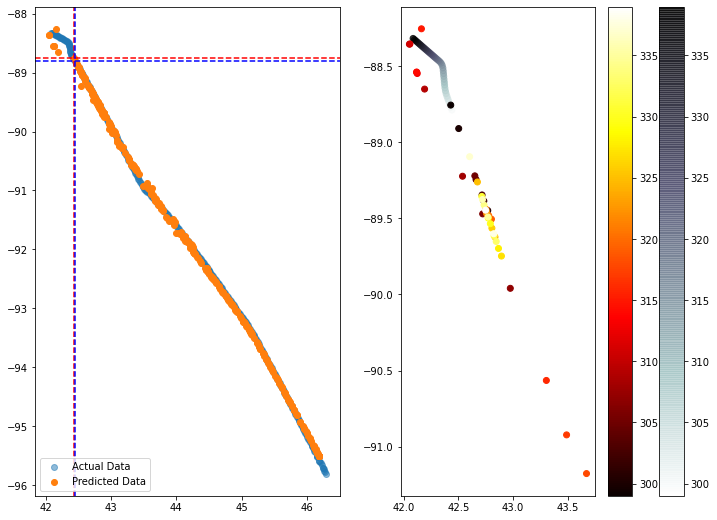

In [26]:
# don't actually know what's happening here...
df_X_ss = ss.transform(x) #old transformers
df_y_mm = mm.transform(y) #old transformers

#print(df_X_ss, len(df_X_ss)) #looks the same when we previously used .fit_transform

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

# looking at our LSTM performance
train_predict = lstm3(df_X_ss)#forward pass for all data rows
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

# must reshape the data so i can plot it...
dataY_plot_f = dataY_plot.flatten()
p_lat = []
p_lon = []
a_lat = []
a_lon = []
for index, element in enumerate(dataY_plot_f):
    if index % 2 == 0:
        a_lat.append(element)
    else:
        a_lon.append (element)
        
data_predict_f = data_predict.flatten()
for index, element in enumerate(data_predict_f):
    if index % 2 == 0:
        p_lat.append(element)
    else:
        p_lon.append (element)

#added this code in hopes of coloring direction/time of my test data.
indexlist=[]
for i, value in enumerate(a_lat):
    indexlist.append(i)
    
#plot of newest lstm        
f, ax = plt.subplots(1,2, figsize=(12, 9))
ax[0].scatter(a_lat,a_lon, label='Actual Data', alpha= .5)#actual data
ax[0].legend(loc='lower left')
ax[0].scatter(p_lat,p_lon, label='Predicted Data')
ax[0].legend(loc='lower left')
ax[0].axvline(x=p_lat[299], c='r', linestyle='--')
ax[0].axhline(y=p_lon[299], c='r', linestyle='--')
ax[0].axvline(x=a_lat[299], c='b', linestyle='--')
ax[0].axhline(y=a_lon[299], c='b', linestyle='--')
ax[0].set_title('Flight 89902f- Additional Variables')

pl1 = ax[1].scatter(a_lat[299:],a_lon[299:], label='Actual Data', alpha= .75, c=indexlist[299:], cmap = 'bone_r')#actual data
plt.colorbar(pl1)
pl2 = ax[1].scatter(p_lat[299:],p_lon[299:], label='Predicted Data', c=indexlist[299:], cmap = 'hot')
plt.colorbar(pl2)
ax[1].set_title('Prediction for Flight 89902f')
# Add basemap
# contextily.add_basemap(
#     ax, 
#     source=contextily.providers.CartoDB.Positron, 
#     crs= 'EPSG:4326'
# )
# #data_predict

In [27]:
# measuring the accuracy of my predicted and the actual points via RMSE
import sklearn.metrics
import math

mse_lat = sklearn.metrics.mean_squared_error(a_lat, p_lat)
rmse_lat = math.sqrt(mse_lat)
mse_lon = sklearn.metrics.mean_squared_error(a_lon, p_lon)
rmse_lon = math.sqrt(mse_lon)

#error based on all of the data (training and test)
print("lat error:", rmse_lat, "lon error:", rmse_lon)

mse_lat_test = sklearn.metrics.mean_squared_error(a_lat[299:], p_lat[299:])
rmse_lat_test = math.sqrt(mse_lat_test)
mse_lon_test = sklearn.metrics.mean_squared_error(a_lon[299:], p_lon[299:])
rmse_lon_test = math.sqrt(mse_lon_test)

#Notices the error is larger when looking at only the test data. RMSE is measured in degrees 
print("lat error:", rmse_lat_test, "lon error:", rmse_lon_test)

#what does this mean in terms of meters or another unit of measure? 
    #converting degrees to meters is a problem, and depends on where in the globe the degree is... 

lat error: 0.19681964164089286 lon error: 0.38554050629678666
lat error: 0.5501053091580412 lon error: 1.082327461323867


### ac9c37 (crazy circles, with relatively low altitude most of the flight)